# Vignette


This vignette extends the [vignette for the R-version of tximport](https://bioconductor.org/packages/release/bioc/vignettes/tximport/inst/doc/tximport.html). If you are unfamiliar with `tximport` or curious about the motivation behind it, please check it out.


If you are looking for a full-featured end-to-end workflow for Pythonic bulk RNA-sequencing analysis, check out our [Snakemake workflow](https://github.com/complextissue/snakemake-bulk-rna-seq-workflow/) based on pytximport.


## Creating your transcript to gene map

Here, we will show you how to generate a transcript-to-gene mapping based on the Ensembl reference or a gene transfer format file.


### Build it from Ensembl


This example requires `pybiomart` which is installed together with `pytximport`. Providing a host is optional, for a list of available archives that correspond to Ensembl releases, please consult [https://www.ensembl.org/info/website/archives/index.html](https://www.ensembl.org/info/website/archives/index.html). By default, the transcript ids will be mapped to the `ensembl_gene_id` field. If you prefer to use gene names, choose `external_gene_name`. Be aware that not all proposed transcripts have been assigned a name yet and thus will not be included if you use gene names. The first time you run this function, it may take a few seconds to download the data.


In [1]:
from pytximport.utils import create_transcript_gene_map

transcript_gene_map_human = create_transcript_gene_map(
    species="human",
    target_field="external_gene_name",
)
transcript_gene_map_human.head(5)

,transcript_id,gene_id
0,ENST00000387314,MT-TF
1,ENST00000389680,MT-RNR1
2,ENST00000387342,MT-TV
3,ENST00000387347,MT-RNR2
4,ENST00000386347,MT-TL1


In [2]:
transcript_gene_map_mouse = create_transcript_gene_map(species="mouse")
transcript_gene_map_mouse.head(5)

,transcript_id,gene_id
0,ENSMUST00000082387,ENSMUSG00000064336
1,ENSMUST00000082388,ENSMUSG00000064337
2,ENSMUST00000082389,ENSMUSG00000064338
3,ENSMUST00000082390,ENSMUSG00000064339
4,ENSMUST00000082391,ENSMUSG00000064340


You can also provide a list of mapping targets as the target_field argument. For example, to map transcripts to both gene names and gene biotypes, you can use the following code:


In [3]:
transcript_gene_map_human_biotype = create_transcript_gene_map(
    species="human",
    target_field=["external_gene_name", "gene_biotype"],
)
transcript_gene_map_human_biotype = transcript_gene_map_human_biotype[
    transcript_gene_map_human_biotype["gene_biotype"] == "lncRNA"
]
transcript_gene_map_human_biotype.head(5)

,transcript_id,gene_id,gene_biotype
94,ENST00000632454,LINC01784,lncRNA
118,ENST00000707308,LINC02688,lncRNA
119,ENST00000707309,LINC02688,lncRNA
164,ENST00000631340,LINC02735,lncRNA
181,ENST00000672718,AGAP12P,lncRNA


### Use a gene transfer format file


If you already have an annotation file in .gtf format (e.g. from the GENCODE or Ensembl references), you can use the `create_transcript_gene_map_from_annotation` function contained in `pytximport.utils` to generate a transcript to gene map. Using an annotation file is considered best practice, as it ensures that your annotation and alignment reference are the same if you download them from the same source, e.g., an Ensembl release.

Set `target_field` to `gene_name` to map transcript ids to gene names instead of gene ids. If the transcript does not have a corresponding gene name in the annotation file, it will be mapped to the gene id.


In [4]:
from pytximport.utils import create_transcript_gene_map_from_annotation

transcript_gene_map_from_gtf = create_transcript_gene_map_from_annotation(
    "../../test/data/annotation.gtf",
    target_field="gene_name",
)
transcript_gene_map_from_gtf.head(5)

,transcript_id,gene_id
0,ENST00000424215,ENSG00000228037
1,ENST00000511072,PRDM16
2,ENST00000607632,PRDM16
3,ENST00000378391,PRDM16
4,ENST00000514189,PRDM16


### Map transcript names to gene names


You can also optionally map transcript names to either gene names or gene ids if your data requires it.


In [5]:
transcript_name_gene_map_human = create_transcript_gene_map(
    "human",
    source_field="external_transcript_name",
    target_field="external_gene_name",
)
transcript_name_gene_map_human.head(5)

,transcript_name,gene_id
0,MT-TF-201,MT-TF
1,MT-RNR1-201,MT-RNR1
2,MT-TV-201,MT-TV
3,MT-RNR2-201,MT-RNR2
4,MT-TL1-201,MT-TL1


## Importing transcript quantification files

You can easily import quantification files from tools like `salmon` with `pytximport`.


In [6]:
import numpy as np
import pandas as pd

from pytximport import tximport

In [7]:
txi = tximport(
    [
        "../../test/data/salmon/multiple/Sample_1.sf",
        "../../test/data/salmon/multiple/Sample_2.sf",
    ],
    "salmon",
    transcript_gene_map_mouse,
    counts_from_abundance="length_scaled_tpm",
    output_type="xarray",  # or "anndata"
)
txi

Reading quantification files: 2it [00:00, 101.58it/s]


<xarray.Dataset> Size: 28kB
Dimensions:    (gene_id: 496, file: 2, file_path: 2)
Coordinates:
  * gene_id    (gene_id) object 4kB 'ENSMUSG00000083355' ... 'ENSMUSG00000067...
  * file_path  (file_path) <U43 344B '../../test/data/salmon/multiple/Sample_...
Dimensions without coordinates: file
Data variables:
    abundance  (gene_id, file) float64 8kB 0.08291 0.0 0.09854 ... 0.4618 0.0
    counts     (gene_id, file) float64 8kB 1.005 0.0 1.086 ... 1.957 6.208 0.0
    length     (gene_id, file) float64 8kB 509.1 509.1 445.8 ... 564.6 564.6

## Exporting transcript-level count estimates


You can also export the transformed transcript counts directly for transcript-level analysis.


In [8]:
txi = tximport(
    ["../../test/data/salmon/quant.sf"],
    "salmon",
    counts_from_abundance="scaled_tpm",
    return_transcript_data=True,
)
txi

Reading quantification files: 1it [00:00, 207.47it/s]


AnnData object with n_obs × n_vars = 1 × 14
    uns: 'counts_from_abundance'
    obsm: 'length', 'abundance'

Note that the example above works without a transcript to gene map. If you want to use the transcript names instead of the transcript ids, you can optionally use the `replace_transcript_ids_with_names` function together with a transcript id to transcript name map.
We can use the `create_transcript_gene_map` function to create a map between transcript ids and transcript names, too.


In [9]:
from pytximport.utils import replace_transcript_ids_with_names

In [10]:
transcript_name_map_human = create_transcript_gene_map("human", target_field="external_transcript_name")
transcript_name_map_human.head(5)

,transcript_id,transcript_name
0,ENST00000387314,MT-TF-201
1,ENST00000389680,MT-RNR1-201
2,ENST00000387342,MT-TV-201
3,ENST00000387347,MT-RNR2-201
4,ENST00000386347,MT-TL1-201


In [11]:
txi = replace_transcript_ids_with_names(txi, transcript_name_map_human)
pd.DataFrame(txi.X.T, index=txi.var.index, columns=txi.obs.index).sort_values(
    by=txi.obs.index[0],
    ascending=False,
).head(5)

,../../test/data/salmon/quant.sf
HOXC8-201,4486.940412
UGT3A2-201,1307.314695
HOXC9-201,886.909534
HOXC4-202,749.069369
HOXC12-201,544.817685


The same data summarized to genes:


In [12]:
txi = tximport(
    ["../../test/data/salmon/quant.sf"],
    "salmon",
    transcript_gene_map_human,
    counts_from_abundance="scaled_tpm",
    output_type="xarray",
    return_transcript_data=False,
)
pd.DataFrame(txi["counts"], index=txi.coords["gene_id"], columns=txi.coords["file_path"]).sort_values(
    by=txi.coords["file_path"].data[0],
    ascending=False,
).head(5)

Reading quantification files: 1it [00:00, 231.92it/s]


,../../test/data/salmon/quant.sf
HOXC8,4486.940412
UGT3A2,1506.597257
HOXC4,1152.964133
HOXC9,886.909534
HOXC12,544.817685


Note that the top transcript corresponds to the top expressed gene in this case.


## Exporting AnnData files


`pytximport` integrates well with other packages from the `scverse` through its `AnnData` export option.


In [13]:
txi_ad = tximport(
    ["../../test/data/salmon/quant.sf"],
    "salmon",
    transcript_gene_map_human,
    output_type="anndata",
    # the output can optionally be saved to a file by uncommenting the following lines
    # output_format="h5ad",
    # output_path="txi_ad.h5ad",
)
txi_ad

Reading quantification files: 1it [00:00, 309.11it/s]


AnnData object with n_obs × n_vars = 1 × 10
    uns: 'counts_from_abundance'
    obsm: 'length', 'abundance'

## Exporting SummarizedExperiment files


Experiment support for SummarizedExperiment files is available through the [BiocPy](https://github.com/biocpy) ecosystem (unaffiliated). While not part of the core functionality of `pytximport`, this output type/format may be useful for interacting with other R software packages. The optional dependencies necessary to support SummarizedExperiment files can be installed via `pip install pytximport[biocpy]`.


In [14]:
txi_se = tximport(
    ["../../test/data/salmon/quant.sf"],
    "salmon",
    transcript_gene_map_human,
    output_type="summarizedexperiment",
    # the output can optionally be saved to disk by uncommenting the following lines
    # output_format="summarizedexperiment",
    # output_path="txi_se",
)
txi_se.assay_names, txi_se.get_row_names(), txi_se.get_column_names()

Reading quantification files: 1it [00:00, 291.19it/s]


(['counts'],
 Names(['UGT3A2', 'HOXC6', 'HOXC9', 'HOXC11', 'HOXC4', 'HOXC10', 'HOXC13', 'HOXC5', 'HOXC8', 'HOXC12']),
 Names(['../../test/data/salmon/quant.sf']))

## Use from the command line

You can run `pytximport` from the command line, too. Available options can be viewed via the `pytximport --help` command.


In [15]:
!pytximport -i ../../test/data/salmon/quant.sf -t "salmon" -m ../../test/data/gencode.v46.metadata.HGNC.tsv -of "h5ad" -ow -o ../../test/data/salmon/quant.h5ad

2025-10-23 23:53:31,869: Starting the import.
Reading quantification files: 1it [00:00, 65.95it/s]
2025-10-23 23:53:32,208: Converting transcript-level expression to gene-level expression.
2025-10-23 23:53:32,269: Matching gene_ids.
2025-10-23 23:53:32,298: Creating gene abundance.
2025-10-23 23:53:32,520: Creating gene counts.
2025-10-23 23:53:32,520: Creating lengths.
2025-10-23 23:53:32,521: Replacing missing lengths.
2025-10-23 23:53:32,528: Creating gene expression dataset.
2025-10-23 23:53:32,530: Saving the gene-level expression to: ../../test/data/salmon/quant.h5ad.
2025-10-23 23:53:32,539: Finished the import in 0.67 seconds.


You can also create a transcript-to-gene mapping via the `pytximport create-map` command.


In [16]:
!pytximport create-map -i ../../test/data/annotation.gtf -o ./transcript_gene_map.tsv -ow

2025-10-23 23:53:33,997: Creating a transcript-to-gene mapping file.
2025-10-23 23:53:34,009: Created the transcript-to-gene mapping file. Saving the file...
2025-10-23 23:53:34,012: Saved the transcript-to-gene mapping file to ./transcript_gene_map.tsv.


## Inferential replicates


`pytximport` can handle bootstraping replicates provided by `salmon` and `kallisto`. When `inferential_replicate_transformer` is set, the provided function is used to recalculate the counts and abundances for each sample based on the bootstraps.


In [17]:
result = tximport(
    [
        "../../test/data/fabry_disease/SRR16504309_wt/",
        "../../test/data/fabry_disease/SRR16504310_wt/",
        "../../test/data/fabry_disease/SRR16504311_ko/",
        "../../test/data/fabry_disease/SRR16504312_ko/",
    ],
    "salmon",
    transcript_gene_map_human,
    inferential_replicates=True,
    inferential_replicate_variance=True,  # whether to calculate the variance of the inferential replicates
    inferential_replicate_transformer=lambda x: np.median(x, axis=1),
    counts_from_abundance="length_scaled_tpm",
)
result

Reading quantification files: 4it [00:01,  2.11it/s]


AnnData object with n_obs × n_vars = 4 × 41127
    uns: 'counts_from_abundance', 'inferential_replicates'
    obsm: 'length', 'abundance', 'variance'

## Biotype filtering


For some use cases, it may be of interest to restrict the results to certain gene_biotypes, e.g., protein-coding only. First, generate a transcript-to-gene mapping from an annotation GTF file that includes the gene biotype.


In [18]:
transcript_gene_map_from_gtf_with_biotype = create_transcript_gene_map_from_annotation(
    "../../test/data/annotation.gtf",
    target_field=["gene_name", "gene_biotype"],
)
transcript_gene_map_from_gtf_with_biotype.head(5)

,transcript_id,gene_id,gene_biotype
0,ENST00000424215,ENSG00000228037,lncRNA
1,ENST00000511072,PRDM16,protein_coding
2,ENST00000607632,PRDM16,protein_coding
3,ENST00000378391,PRDM16,protein_coding
4,ENST00000514189,PRDM16,protein_coding


Then, import quantification files using the transcript-to-gene mapping and filter the counts by biotype.


In [19]:
from pytximport.utils import filter_by_biotype

result_small = tximport(
    ["../../test/data/fabry_disease/SRR16504309_wt/"],
    "salmon",
    transcript_gene_map_from_gtf_with_biotype,
    counts_from_abundance="length_scaled_tpm",
)

result_small_filtered = filter_by_biotype(
    result_small,
    transcript_gene_map_from_gtf_with_biotype,
    biotype_filter=["protein_coding"],
    # Since the data is already at the gene level, we have to use the gene_id from the transcript_gene_map
    id_column="gene_id",
)

len(result_small.var_names), len(result_small_filtered.var_names)

Reading quantification files: 1it [00:00,  2.60it/s]


(12, 4)

## Downstream analysis with PyDESeq2

The output from `pytximport` can easily be used for downstream analysis with `PyDESeq2`. For more information on `PyDESeq2`, please consult its [documentation](https://pydeseq2.readthedocs.io/en/latest/).


In [20]:
import decoupler as dc
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

/Users/malte/pytximport/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the .csv file generated by `pytximport` via the `output_path` argument or create it directly from the output of `pytximport`. In this case, we are working with the salmon quantification files from a public bulk RNA sequencing dataset: [Podocyte injury in Fabry nephropathy](https://www.ebi.ac.uk/ena/browser/view/PRJNA773084)


Round count estimates (required by PyDESeq2) and add the corresponding metadata.


In [21]:
result.X = result.X.round().astype(int)
result.obs["condition"] = ["Control", "Control", "Disease", "Disease"]
result

AnnData object with n_obs × n_vars = 4 × 41127
    obs: 'condition'
    uns: 'counts_from_abundance', 'inferential_replicates'
    obsm: 'length', 'abundance', 'variance'

Filter genes with low counts out.


In [22]:
result = result[:, result.X.max(axis=0) > 10].copy()
result

AnnData object with n_obs × n_vars = 4 × 14776
    obs: 'condition'
    uns: 'counts_from_abundance', 'inferential_replicates'
    obsm: 'length', 'abundance', 'variance'

Now perform your `PyDESeq2` analysis.


In [23]:
dds = DeseqDataSet(
    adata=result,
    design="~condition",
    refit_cooks=True,
    inference=DefaultInference(n_cpus=8),
    quiet=True,
)

In [24]:
dds.deseq2()

/Users/malte/pytximport/.venv/lib/python3.13/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()


In [25]:
stat_result = DeseqStats(dds, contrast=["condition", "Disease", "Control"], quiet=True)

In [26]:
stat_result.summary()
stat_result.lfc_shrink(coeff="condition[T.Disease]")

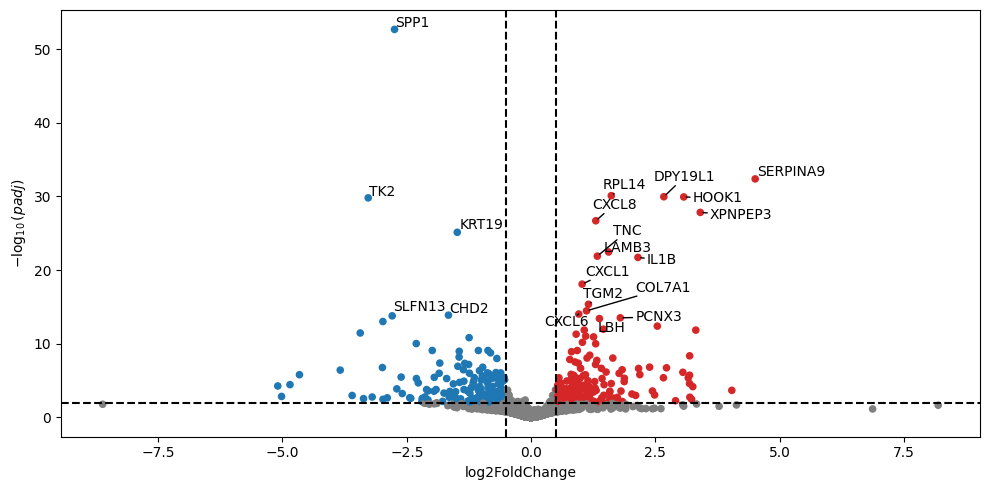

In [27]:
dc.pl.volcano(
    stat_result.results_df,
    x="log2FoldChange",
    y="padj",
    thr_sign=0.01,
    top=20,
    figsize=(10, 5),
)

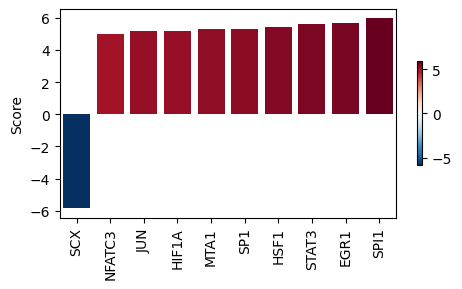

In [28]:
collectri = dc.op.collectri(organism="human", remove_complexes=False)
data = stat_result.results_df[["stat"]].T.rename(index={"stat": "disease.vs.control"})
tf_acts, tf_pvals = dc.mt.ulm(data=data, net=collectri, tmin=5)
dc.pl.barplot(data=tf_acts, name="disease.vs.control", top=10, vertical=True, figsize=(5, 3))

We can also evaluate known pathways.


In [29]:
progeny = dc.op.progeny(organism="human", top=500)
pathway_acts, pathway_pvals = dc.mt.ulm(data=data, net=progeny, tmin=5)

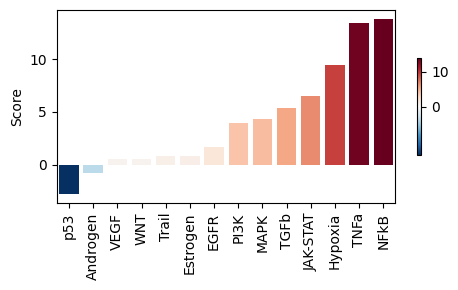

In [30]:
dc.pl.barplot(
    data=pathway_acts,
    name="disease.vs.control",
    top=40,
    vertical=True,
    figsize=(5, 3),
)

Please refer to the `PyDESeq2` and the `decoupler` documentation for additional analyses.
